In [11]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

# Load data

In [17]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    # Calculate trip duration in minutes
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # Filter on trips between 1 and 60 minutes
    df = df[((df.duration >=1) & (df.duration <= 60))]
    
    # Select categorical and numerical variables
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    # Add combinations of pickup and dropoff locations
    df["PU_DO"] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str)
    
    # Convert the catergoricals to strings (they are integers originally).
    df.loc[:, categorical] = df[categorical].astype(str)
    
    return df

In [4]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

len(df_train), len(df_val)

/tmp/ipykernel_37001/4073654839.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['43' '166' '41' ... '74' '168' '119']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, categorical] = df[categorical].astype(str)
/tmp/ipykernel_37001/4073654839.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['151' '239' '42' ... '69' '215' '244']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, categorical] = df[categorical].astype(str)
/tmp/ipykernel_37001/4073654839.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['130' '152' '152' ... '74' '42' '42']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, categorical] = df[categor

(73908, 61921)

In [5]:
# Filter on trip_type == Dispatch
# df[df.trip_type == 2]

In [13]:
# Select categorical and numerical variables
categorical = ['PULocationID', 'DOLocationID', 'PU_DO']
numerical = ['trip_distance']



dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

# Vectorize
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Set target variable
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

# Train linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on the train set
y_pred_train = lr.predict(X_train)

# Predict on the val set
y_pred_val = lr.predict(X_val)

# Calculate error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)

print(f"mse_train: {mse_train}")
print(f"mse_val: {mse_val}")

print(f"root_mse_train: {np.sqrt(mse_train)}")
print(f"root_mse_val: {np.sqrt(mse_val)}")

with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

mse_train: 34.796383463695996
mse_val: 59.666722978173155
root_mse_train: 5.89884594337706
root_mse_val: 7.724423795868088


In [7]:
# Try Lasso model
lr = Lasso()
lr.fit(X_train, y_train)

y_pred_val = lr.predict(X_val)

# Calculate error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)

print(f"root_mse_train: {np.sqrt(mse_train)}")
print(f"root_mse_val: {np.sqrt(mse_val)}")

root_mse_train: 5.89884594337706
root_mse_val: 12.212583224318818


In [8]:
# Try Ridge model
lr = Ridge()
lr.fit(X_train, y_train)

y_pred_val = lr.predict(X_val)

# Calculate error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)

print(f"root_mse_train: {np.sqrt(mse_train)}")
print(f"root_mse_val: {np.sqrt(mse_val)}")

root_mse_train: 5.89884594337706
root_mse_val: 7.484704893625263


In [9]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 295632 stored elements and shape (73908, 13727)>

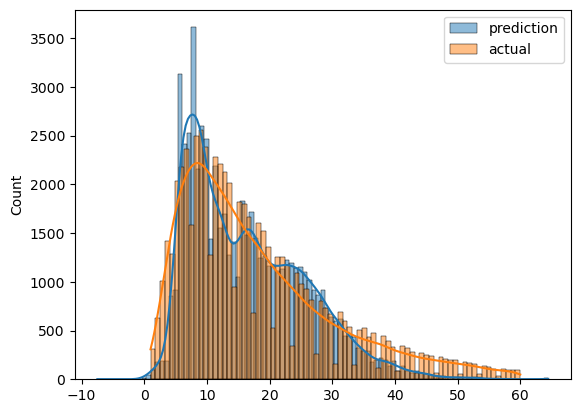

In [16]:
# Visualise the results
sns.histplot(y_pred_val, label='prediction', kde=True, alpha=0.5)
sns.histplot(y_val, label='actual', kde=True, alpha=0.5)
plt.legend()

In [ ]:
LassoRegression